In [147]:
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from PIL import Image
from scipy.stats import entropy
import cv2

In [148]:
def compute_histograms(images, labels, n_clusters, num_bins=256):
    histograms = [[] for _ in range(n_clusters)]
    for img, label in zip(images, labels):
        hist, _ = np.histogram(img, bins=num_bins, range=(0, 255))
        histograms[label].append(hist)
    return histograms


In [149]:
def plot_cluster_histograms(histograms):
    for cluster_idx, cluster_histograms in enumerate(histograms):
        plt.figure(figsize=(10, 6))
        for hist in cluster_histograms:
            plt.plot(hist)
        plt.title(f"Cluster {cluster_idx} Histograms")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.xlim(0,8)
        plt.show()

In [150]:
def plot_average_histograms(histograms):
    plt.figure(figsize=(10, 6))
    for cluster_idx, cluster_histograms in enumerate(histograms):
        average_histogram = np.mean(cluster_histograms, axis=0)
        plt.plot(average_histogram, label=f"Cluster {cluster_idx}")
    plt.title("Average Histograms")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim(0,8)
    plt.legend()
    plt.show()

In [181]:
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('L')
        if img is not None:
            img = np.array(img).flatten()  # Convert the image to a 1D array
            images.append(img)
            filenames.append(filename)
    return images, filenames

In [152]:
def compute_statistics(images, labels, n_clusters):
    cluster_stats = []
    for i in range(n_clusters):
        cluster_images = [img for img, label in zip(images, labels) if label == i]

        # 표준 편차 및 분산 계산
        std_devs = [np.std(img) for img in cluster_images]
        variances = [np.var(img) for img in cluster_images]

        # 엔트로피 계산
        entropies = []
        for img in cluster_images:
            hist, _ = np.histogram(img, bins=256, range=(0, 255), density=True)
            hist += 1e-9  # 0 값을 피하기 위한 작은 값 추가
            entropies.append(entropy(hist))

        cluster_stats.append({
            'standard_deviations': std_devs,
            'variances': variances,
            'entropies': entropies
        })
    return cluster_stats


In [153]:
def print_statistics(cluster_stats):
    for idx, stats in enumerate(cluster_stats):
        print(f"Cluster {idx}:")
        print(f"  Standard Deviation: Mean = {np.mean(stats['standard_deviations']):.4f}, Min = {np.min(stats['standard_deviations']):.4f}, Max = {np.max(stats['standard_deviations']):.4f}")
        print(f"  Variance: Mean = {np.mean(stats['variances']):.4f}, Min = {np.min(stats['variances']):.4f}, Max = {np.max(stats['variances']):.4f}")
        print(f"  Entropy: Mean = {np.mean(stats['entropies']):.4f}, Min = {np.min(stats['entropies']):.4f}, Max = {np.max(stats['entropies']):.4f}")


In [154]:
def plot_statistics(cluster_stats):
    mean_std_devs = [np.mean(stats['standard_deviations']) for stats in cluster_stats]
    mean_variances = [np.mean(stats['variances']) for stats in cluster_stats]
    mean_entropies = [np.mean(stats['entropies']) for stats in cluster_stats]

    min_std_devs = [np.min(stats['standard_deviations']) for stats in cluster_stats]
    min_variances = [np.min(stats['variances']) for stats in cluster_stats]
    min_entropies = [np.min(stats['entropies']) for stats in cluster_stats]

    max_std_devs = [np.max(stats['standard_deviations']) for stats in cluster_stats]
    max_variances = [np.max(stats['variances']) for stats in cluster_stats]
    max_entropies = [np.max(stats['entropies']) for stats in cluster_stats]

    clusters = range(len(cluster_stats))

    plt.figure(figsize=(10, 6))
    plt.plot(clusters, mean_std_devs, label='Mean Standard Deviation')
    plt.plot(clusters, mean_variances, label='Mean Variance')
    plt.plot(clusters, mean_entropies, label='Mean Entropy')
    plt.fill_between(clusters, min_std_devs, max_std_devs, alpha=0.1)
    plt.fill_between(clusters, min_variances, max_variances, alpha=0.1)
    plt.fill_between(clusters, min_entropies, max_entropies, alpha=0.1)
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Cluster Statistics')
    plt.show()


In [155]:
def apply_gabor_filter(image, ksize, sigma, theta, lambd, gamma, psi):
    gabor_filter = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    return cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)

In [156]:
def is_striped_pattern(image):
    some_variance_threshold = 1
    filtered_image = apply_gabor_filter(image, ksize=(13, 13), sigma=8.0, theta=np.pi/4, lambd=10.0, gamma=0.5, psi=0)
    variance = np.var(filtered_image)

    return variance > some_variance_threshold

In [157]:
def analyze_clusters(images, labels, n_clusters):
    some_contrast_threshold = 1
    low_contrast_clusters = []
    striped_clusters = []

    for i in range(n_clusters):
        cluster_images = [img.reshape(image_shape) for img, label in zip(images, labels) if label == i] # Assuming images were flattened earlier

        # 평균 contrast 측정 (표준 편차로)
        avg_contrast = np.mean([np.std(img) for img in cluster_images])

        # 줄무늬 패턴 확인
        striped_pattern_detected = any(is_striped_pattern(img) for img in cluster_images)

        if avg_contrast < some_contrast_threshold:
            low_contrast_clusters.append(i)
        if striped_pattern_detected:
            striped_clusters.append(i)

    return low_contrast_clusters, striped_clusters

In [189]:
def visualize_striped_pattern_detection(images, labels, cluster_id):
    cluster_images = [img.reshape(image_shape) for img, label in zip(images, labels) if label == cluster_id]

    for img in cluster_images:
        filtered_image = apply_rotation_invariant_gabor_filter(img, ksize=(13, 13), sigma=2.0, lambd=10.0, gamma=0.5, psi=0)

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(filtered_image, cmap='gray')
        plt.title('Gabor Filtered Image')

        plt.show()


In [177]:
def visualize_gabor_filtering(original_image, filtered_image):
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot Gabor filtered image
    plt.subplot(1, 2, 2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')

    plt.show()


In [159]:
def analyze_striped_pattern_detection(images, labels, n_clusters):
    for i in range(n_clusters):
        cluster_images = [img.reshape(image_shape) for img, label in zip(images, labels) if label == i]
        striped_pattern_count = sum(is_striped_pattern(img) for img in cluster_images)
        percentage = (striped_pattern_count / len(cluster_images)) * 100

        print(f'Cluster {i}: {striped_pattern_count} out of {len(cluster_images)} images detected as striped pattern ({percentage:.2f}%)')


In [175]:
def apply_rotation_invariant_gabor_filter(image, ksize, sigma, lambd, gamma, psi, angles=8):
    total_response = np.zeros_like(image, dtype=np.float32)

    # 이미지를 float32 형식으로 변환
    image_float32 = image.astype(np.float32)

    # 각도별로 필터 적용
    for angle in range(angles):
        theta = angle * np.pi / angles
        kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
        response = cv2.filter2D(image_float32, cv2.CV_32F, kernel)
        total_response += response

    # 각도별 응답의 평균 계산
    average_response = total_response / angles
    return average_response

In [183]:
folder = '/home/rtlink/jiwon/paper_ws/heightmaps_30'  # replace with your folder path
images, filenames = load_images_from_folder(folder)

In [184]:
# Scale data
scaler = StandardScaler()
images = scaler.fit_transform(images)

n_clusters = 4  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0, init="random").fit(images)

labels = kmeans.labels_

/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [185]:
# Create a new directory for each cluster and copy the images into the correct directories
for i in range(len(labels)):
    label = labels[i]
    filename = filenames[i]
    directory = os.path.join(folder, str(label))
    if not os.path.exists(directory):
        os.makedirs(directory)
    shutil.copy2(os.path.join(folder, filename), directory)

In [163]:
histograms = compute_histograms(images, labels, n_clusters)

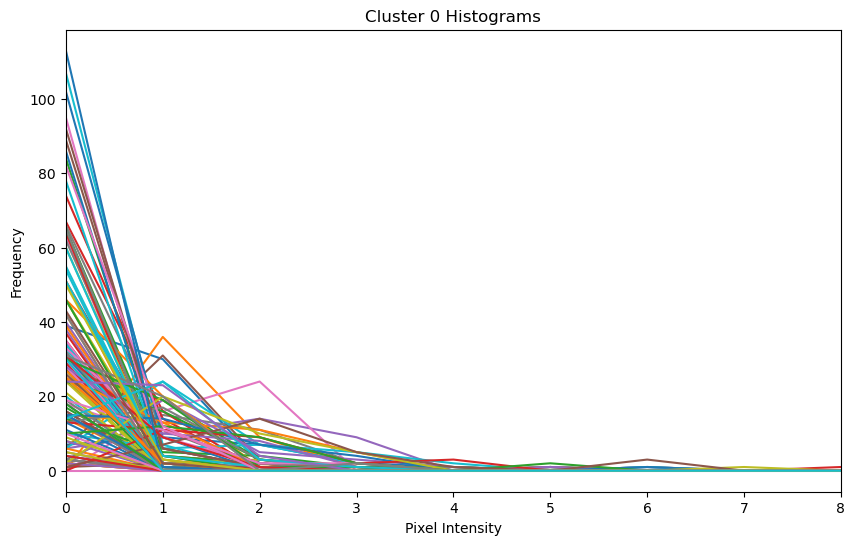

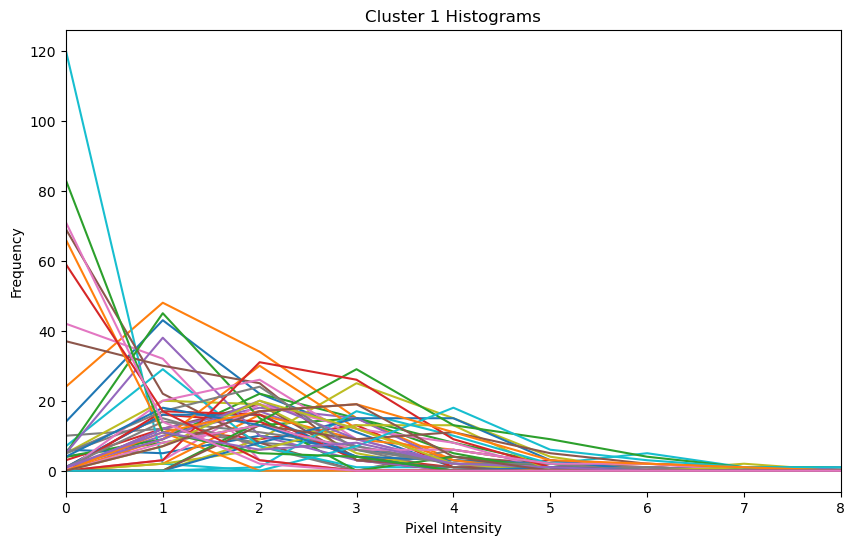

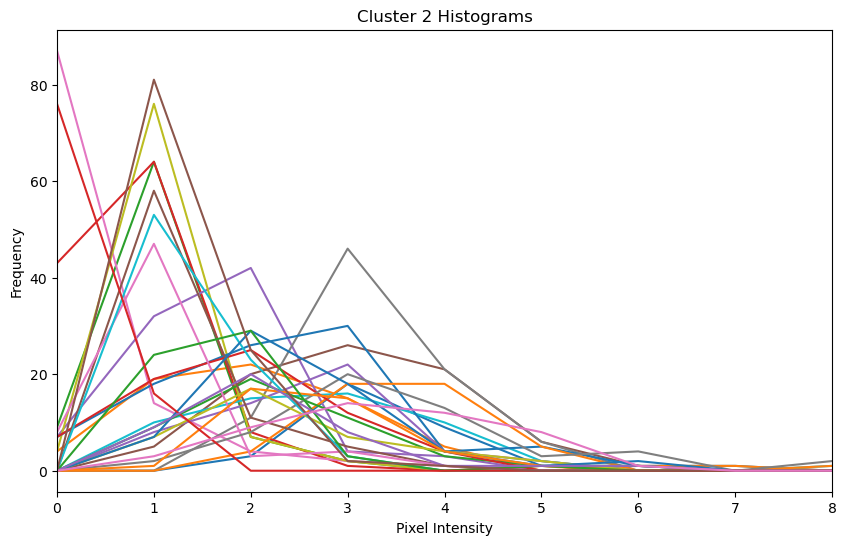

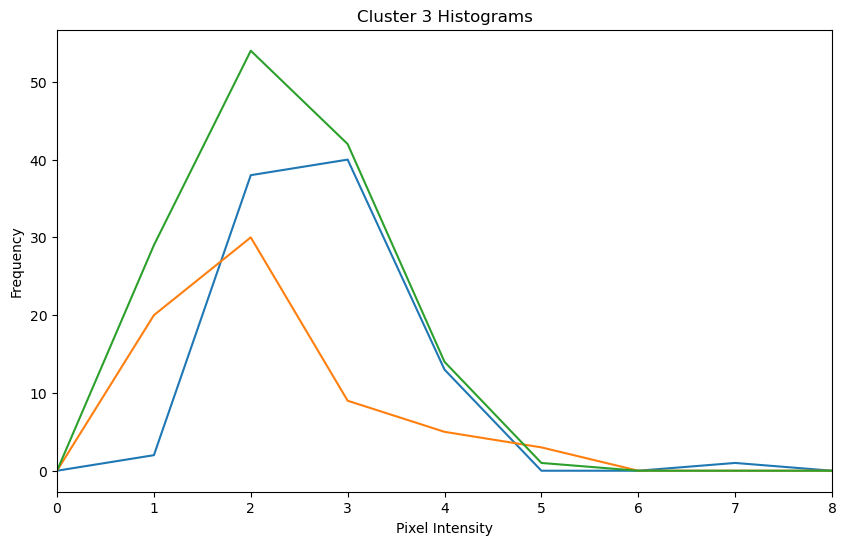

In [164]:
plot_cluster_histograms(histograms)

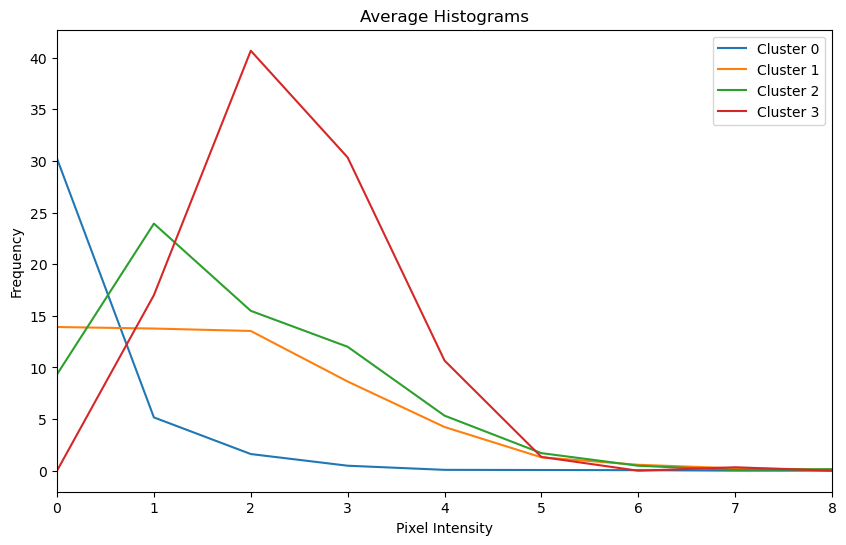

In [165]:
plot_average_histograms(histograms)

In [166]:
cluster_stats = compute_statistics(images, labels, n_clusters)
print_statistics(cluster_stats)

Cluster 0:
  Standard Deviation: Mean = 0.4208, Min = 0.1072, Max = 1.2461
  Variance: Mean = 0.2463, Min = 0.0115, Max = 1.5527
  Entropy: Mean = nan, Min = nan, Max = nan
Cluster 1:
  Standard Deviation: Mean = 1.2881, Min = 0.4284, Max = 2.2060
  Variance: Mean = 1.8226, Min = 0.1835, Max = 4.8662
  Entropy: Mean = 1.2446, Min = 0.0837, Max = 1.7557
Cluster 2:
  Standard Deviation: Mean = 1.3934, Min = 0.5898, Max = 2.1902
  Variance: Mean = 2.1020, Min = 0.3479, Max = 4.7968
  Entropy: Mean = 1.1521, Min = 0.4620, Max = 1.7388
Cluster 3:
  Standard Deviation: Mean = 1.7073, Min = 1.4853, Max = 1.9644
  Variance: Mean = 2.9537, Min = 2.2061, Max = 3.8589
  Entropy: Mean = 1.2745, Min = 1.1800, Max = 1.3231


/home/rtlink/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


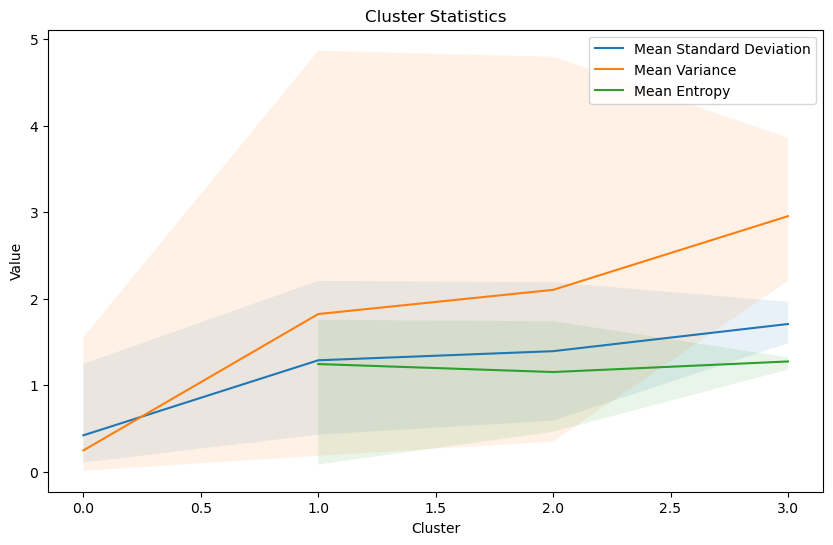

In [167]:
plot_statistics(cluster_stats)

In [168]:
some_contrast_threshold = 10 # 임계값 설정
image_shape = (15, 15) # 실제 이미지의 크기 설정
low_contrast_clusters, striped_clusters = analyze_clusters(images, labels, n_clusters)



In [ ]:
visualize_striped_pattern_detection(images, labels, cluster_id=0)

In [191]:
analyze_striped_pattern_detection(images, labels, n_clusters)

Cluster 0: 92 out of 130 images detected as striped pattern (70.77%)
Cluster 1: 47 out of 47 images detected as striped pattern (100.00%)
Cluster 2: 27 out of 27 images detected as striped pattern (100.00%)
Cluster 3: 3 out of 3 images detected as striped pattern (100.00%)


In [186]:

# 예시 사용 방법
ksize = (7, 7)
sigma = 2.0
lambd = 10.0
gamma = 0.5
psi = 0
filtered_image = apply_rotation_invariant_gabor_filter(images, ksize, sigma, lambd, gamma, psi)


In [194]:
import os

def save_clustered_images(images, labels, folder_name, prefix='original'):
    for i, label in enumerate(labels):
        directory = os.path.join(folder_name, f"{prefix}_cluster_{label}")
        if not os.path.exists(directory):
            os.makedirs(directory)
        img = images[i].reshape(image_shape)
        
        # 이미지를 0-255 범위로 스케일링하고 uint8로 변환
        img_scaled = (255.0 / img.max() * (img - img.min())).astype(np.uint8)

        img_path = os.path.join(directory, f"{prefix}_image_{i}.png")
        Image.fromarray(img_scaled).save(img_path)


# 폴더 이름 지정
folder_name = '/home/rtlink/jiwon/paper_ws/heightmaps_30'  # 이 부분을 원하는 경로로 변경하세요

# 원본 이미지 저장
save_clustered_images(images, original_labels, folder_name, prefix='original')

# Gabor 필터링된 이미지 저장
filtered_images_reshaped = [img.reshape(image_shape) for img in filtered_images]
save_clustered_images(filtered_images_reshaped, filtered_labels, folder_name, prefix='filtered')


In [ ]:
def kmeans_clustering(images, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init="random").fit(images)
    return kmeans.labels_

# 원본 이미지에 k-means 적용
original_labels = kmeans_clustering(images, n_clusters)

# Gabor 필터링된 이미지에 k-means 적용
filtered_images = [apply_rotation_invariant_gabor_filter(img.reshape(image_shape), ksize=(13, 13), sigma=2.0, lambd=10.0, gamma=0.5, psi=0).flatten() for img in images]
filtered_labels = kmeans_clustering(filtered_images, n_clusters)

# 원본 및 Gabor 필터링된 이미지의 클러스터링 결과 시각화
for i in range(len(images)):
    original_image = images[i].reshape(image_shape)
    filtered_image = filtered_images[i].reshape(image_shape)

    plt.subplot(2, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original Image\nCluster {original_labels[i]}')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f'Gabor Filtered Image\nCluster {filtered_labels[i]}')
    plt.axis('off')

    plt.show()

In [195]:
from scipy.stats import entropy

def extract_features_from_gabor_response(response):
    mean_response = np.mean(response)
    std_response = np.std(response)
    entropy_response = entropy(response.ravel())
    return mean_response, std_response, entropy_response

# 클러스터별로 특징 추출
cluster_features = []
for cluster_id in range(n_clusters):
    cluster_images = [img.reshape(image_shape) for img, label in zip(images, labels) if label == cluster_id]
    
    features = []
    for img in cluster_images:
        filtered_image = apply_rotation_invariant_gabor_filter(img, ksize=(13, 13), sigma=2.0, lambd=10.0, gamma=0.5, psi=0)
        features.append(extract_features_from_gabor_response(filtered_image))

    # 클러스터별 특징의 평균 계산
    cluster_features.append(np.mean(features, axis=0))

# 특정 기준(예: 평균 응답)으로 클러스터 정렬
sorted_clusters = sorted(range(n_clusters), key=lambda x: cluster_features[x][0])

print("Clusters sorted by mean Gabor response:", sorted_clusters)

Clusters sorted by mean Gabor response: [0, 1, 2, 3]
